# Text Sentiment Classification

## Overview

**Sentiment Classification** is an automated process of identifying opinions in text and labeling them as positive, negative, or neutral, based on the emotions customers express within them.

We will train a recurrent neural network (RNN)
or fine-tune a pre-trained language model (e.g., BERT) to predict the
sentiment of given tweet.

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.  
We use `python==3.7.14`, `torch==1.12.1+cu113` and `torchvision==0.13.1+cu113`.  
This is the default version in Google Colab.

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.8.15 (default, Oct 12 2022, 19:14:39) 
torch 1.12.1+cu113
torchvision 0.13.1+cu113


## Loading Model and Data

First, we are going to talk about the model.  
HuggingFace team have created an amazing framework called "transformers" for NLP tasks.  
It havs many State-of-the-art Machine Learning for Pytorch, TensorFlow, and JAX.  

To start with this package, follow [this link to installation and basic tutorial](https://pytorch.org/hub/huggingface_pytorch-transformers/).

In [ ]:
# some installations there
!echo happy installation
!pip -V
!pip install transformers datasets

happy installation
pip 21.1.3 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Implement Pretrained Model using PyTorch

In [ ]:
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, XLMRobertaForSequenceClassification

bert_type = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

model = AutoModelForSequenceClassification.from_pretrained("roberta-base",
                                                           num_labels = 3,
                                                           # attention_probs_dropout_prob = 0.3,
                                                           # hidden_dropout_prob = 0.3
                                                          )

# use this part to adjust the output from the model you use in your task if it's needed
# model.classifier = nn.Sequential(nn.Linear(768, 50),
                                 # nn.ReLU(),
                                 # nn.Dropout(0.5),
                                 # nn.Linear(50, 3, bias = True) 
                                 # )

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.





## How to Get Data

Please open the file `twitter_sentiment.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/14SdYQ6FSowQnWVCd4dP12jQMjX9-YJIh/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzip Data

Unzip `twitter_sentiment.zip`, there are 3 csv files.

- `train.csv`, `test.csv` and `val.csv`

There are **10248** datas in training set.  
There are **1461** datas in validation set.  
There are **2928** datas in testing set.  

In [ ]:
!unzip -qq ./drive/MyDrive/A5_data_twitter_sentiment.zip

In [ ]:
# Utility function to extract text and label from csv file
def get_texts(f_name='./twitter_sentiment', mode='train'):
    text_list = []
    label_list = []
    
    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path) as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

In [ ]:
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train'):
        self.mode = mode
        
        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']

        self.label_list = label_list
    
    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

In [ ]:
dataset_train = TwitterDataset(mode='train')
dataset_val = TwitterDataset(mode='val')
dataset_test = TwitterDataset(mode='test')

batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1464 datas
mode test has 2928 datas


In [ ]:
t = tokenizer.convert_ids_to_tokens(dataset_train[0][0])
print('token', t)
print('token to s', tokenizer.convert_tokens_to_string(t))

token ['<s>', '@', 'united', 'Ġsat', 'Ġat', 'Ġairport', 'Ġfor', 'Ġ5', 'Ġhrs', 'Ġstill', 'Ġsitting', 'Ġat', 'Ġgate', '..', 'Ġ', 'ĠS', 'igh', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [ ]:
device = torch.device('cuda')

from torch import nn
import torch.optim as optim
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [4, 8], gamma = 0.1)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

## Utility Function

In [ ]:
def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_loss_list = []
val_loss_list = []

def train(model, data, optimizer, criterion):
    model.train()
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        out = model(text,mask)

        loss = criterion(out.logits,label)
        acc = accuracy(out.logits, label)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        train_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def test(model, data, criterion, log_loss=False):
    model.eval()
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        out = model(text,mask)

        loss = criterion(out.logits,label)
        acc = accuracy(out.logits, label)

        epoch_loss += loss.item()
        if log_loss:
            val_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

# class for monitoring train and test acc/loss
class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []
    
    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)
    
    def plot(self):
        x = range(len(self.train_loss_list))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

## Start Training

In [ ]:
# Hyper-parameters                             
max_epoch = 10
log_interval = 1
best_acc = 0

m = Meter()

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model, train_data, optimizer, criterion)
    val_loss, val_acc = test(model, val_data, criterion, log_loss=True)
    
    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))
    
    m.update(train_loss, train_acc, val_loss, val_acc)
    
    # model checkpoint
    torch.save(model.state_dict(), 'ckpts_e{}.pt'.format(epoch))
    if val_acc > best_acc:
        best_model = model
        best_acc = val_acc
        print('-'*10, 'e', epoch, 'save best model', '-'*10)

100%|██████████| 46/46 [00:04<00:00,  9.36it/s]


Epoch 1 train_loss: 0.008753594909674669 train_acc: 0.7715651834504293
Epoch 1 val_loss:  0.011937850572250254 val_acc : 0.8592896174863388
---------- e 1 save best model ----------


100%|██████████| 46/46 [00:04<00:00,  9.43it/s]


Epoch 2 train_loss: 0.00538353230964151 train_acc: 0.8711943793911007
Epoch 2 val_loss:  0.011240944225605719 val_acc : 0.8668032786885246
---------- e 2 save best model ----------


100%|██████████| 46/46 [00:04<00:00,  9.35it/s]


Epoch 3 train_loss: 0.004196495442977647 train_acc: 0.907103825136612
Epoch 3 val_loss:  0.012325700397903476 val_acc : 0.8592896174863388


100%|██████████| 46/46 [00:04<00:00,  9.37it/s]


Epoch 4 train_loss: 0.003360468060705901 train_acc: 0.9258391881342701
Epoch 4 val_loss:  0.012746358427722922 val_acc : 0.8674863387978142
---------- e 4 save best model ----------


100%|██████████| 46/46 [00:04<00:00,  9.36it/s]


Epoch 5 train_loss: 0.0024398153009450034 train_acc: 0.9485753317720531
Epoch 5 val_loss:  0.014998216535692496 val_acc : 0.8613387978142076


100%|██████████| 46/46 [00:04<00:00,  9.38it/s]


Epoch 6 train_loss: 0.0018113573731754228 train_acc: 0.9626268540202967
Epoch 6 val_loss:  0.0164602085059926 val_acc : 0.860655737704918


100%|██████████| 46/46 [00:04<00:00,  9.39it/s]


Epoch 7 train_loss: 0.0015546157084598811 train_acc: 0.9691647150663544
Epoch 7 val_loss:  0.017246173684551416 val_acc : 0.8579234972677595


100%|██████████| 46/46 [00:04<00:00,  9.41it/s]


Epoch 8 train_loss: 0.00121952073224533 train_acc: 0.9755074160811865
Epoch 8 val_loss:  0.017487091055557215 val_acc : 0.8633879781420765


100%|██████████| 46/46 [00:04<00:00,  9.39it/s]


Epoch 9 train_loss: 0.0010517187491800872 train_acc: 0.9780444964871194
Epoch 9 val_loss:  0.018920031406718198 val_acc : 0.8579234972677595


100%|██████████| 46/46 [00:04<00:00,  9.38it/s]


Epoch 10 train_loss: 0.000902640451164589 train_acc: 0.9829234972677595
Epoch 10 val_loss:  0.021096085311458165 val_acc : 0.860655737704918


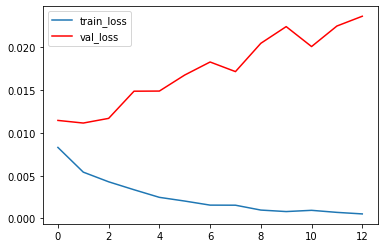

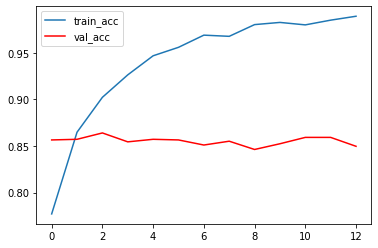

In [ ]:
# plot them out
m.plot()

## Prediction

In [ ]:
# # if you wanna load previous best model
ckpt = torch.load('ckpts_e3.pt') # (change the file name of model if it's needed)
best_model.load_state_dict(ckpt) 

<All keys matched successfully>

In [ ]:
best_model.eval()

total_out = []
for text, mask in tqdm(test_data, total=len(test_data)):
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    pred = output.logits
    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

100%|██████████| 92/92 [00:10<00:00,  8.62it/s]
